In [2]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from tqdm.auto import tqdm

# Xarxes convolucionals

L'objectiu d'avui és la creació d'una xarxa convolucional que obtengui **com a mínim igual resultat que la xarxa completament connectada implementada la setmana anterior però amb menys paràmetres**. Per poder realitzar comparacions directes emprarem el mateix conjunt de dades.

Com objectius secundaris tenim:

1. Aprenentatge de noves estratègies per evitar `overfitting`.
2. Visualització dels resultats dels filtres convolucionals.

Primer de tot, com sempre, les dades:

In [3]:
DOWNLOAD = True
BATCH_SIZE = 64
EPOCHS = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # mitjana, desviació típica
])

train = datasets.MNIST("../data", train=True, download=DOWNLOAD, transform=transform)
test = datasets.MNIST("../data", train=False, download=DOWNLOAD, transform=transform)

train_loader = torch.utils.data.DataLoader(train, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test, BATCH_SIZE)

In [4]:
img, target = next(iter(train_loader))
print(img.shape)

torch.Size([64, 1, 28, 28])


## Definició de la xarxa

En primer lloc, reutilitzarem la xarxa (MLP) que varem dissenyar la sessió anterior:

In [5]:
model_mlp = nn.Sequential(
            torch.nn.Linear(784, 10),
            nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.Dropout(0.2),
            nn.ReLU(),
            torch.nn.Linear(10, 1)
        )


En segon lloc, definirem la nostra primera xarxa convolucional:

1. Definir la primera xarxa convolucional. A continuació teniu una llista de les capes que podeu emprar:

- `Conv2d`: Capa convolucional en 2 dimensions ([enllaç](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)). Com a paràmetres principals trobarem: ([visualització](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md))

  - in_channels: canals d'entrada.
  - out_channels : canals de sortida.
  - kernel_size: mida del filtre.
  - stride: desplaçament del filtre. Típicament pren per valor 1.
  - padding: ampliació de la imatge per evitar pèrdua de dimensionalitat.

- `MaxPool2d`: Capa de max pooling ([enllaç](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)). Aquesta capa no té paràmetres entrenables. Però en té d'altres:

  - kernel_size: Mida del filtre del qual es seleccionarà el màxim.
  - stride: desplaçament del filtre.

- `Dropout`: Dropout és un mètode de regularització (evitar `overfitting`) que aproxima l'entrenament d'un gran nombre de xarxes neuronals amb diferents arquitectures en paral·lel. Durant l'entrenament, una part de les sortides de la capa s'ignoren aleatòriament o s'abandonen. Això té l'efecte de fer que la capa sembli i es tracti com una capa amb un nombre diferent de nodes i connectivitat a la capa anterior. En efecte, cada actualització d'una capa durant l'entrenament es realitza amb una vista diferent de la capa configurada. Hem d'especificar quines capes tenen `dropout` de manera individual. Té un únic paràmetre amb valor per defecte $p=0.5$ Els valors típics d'aquest paràmetre varien entre $0.5$ i $0.8$.

- `Linear`

- `ReLU`


In [6]:
model_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(32 * 4 * 4, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 10)
)


## Entrenament MLP

Aquesta part, per sort, no varia de la setmana anterior:




In [7]:
loss_fn = torch.nn.BCEWithLogitsLoss()    
learning_rate =  1e-3 # Hiperparàmetre
optimizer = optim.Adam(model_mlp.parameters(), lr=learning_rate)

In [8]:
running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0
    
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"): 
        model_mlp.train() # Posam el model a mode entranament.
        
        x = x.reshape(x.shape[0], -1) # Aplanam la imatge.
        
        optimizer.zero_grad()

        # 1. PREDICCIÓ
        y_pred = model_mlp(x)

        # 2. CÀLCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        y_binary = (y == 5)
        y_binary = y_binary.double()
        y_binary = y_binary.reshape(-1, 1)

        loss = loss_fn(y_pred, y_binary)

        #3. GRADIENT
        model_mlp.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIÓ
        with torch.no_grad():
            optimizer.step()
    
        # 5. AVALUAM EL MODEL
        model_mlp.eval() # Mode avaluació de la xarxa
        
        y_pred = model_mlp(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_loss += (loss_fn(y_pred, y_binary).detach())
        batch_acc += accuracy_score(y_pred_binary.detach(), y_binary.detach())

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0
    
    for i_batch, (x, y) in enumerate(test_loader): 
        x = x.reshape(x.shape[0], -1) # Aplanam la imatge.
        
        y_binary = (y == 5)
        y_binary = y_binary.double()
        y_binary = y_binary.reshape(-1, 1)

        y_pred = model_mlp(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_test_loss += (loss_fn(y_pred, y_binary).detach())
        acc = accuracy_score(y_pred_binary.detach(), y_binary.detach())
        batch_test_acc += acc
        

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc.append(batch_test_acc / (i_batch + 1))

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

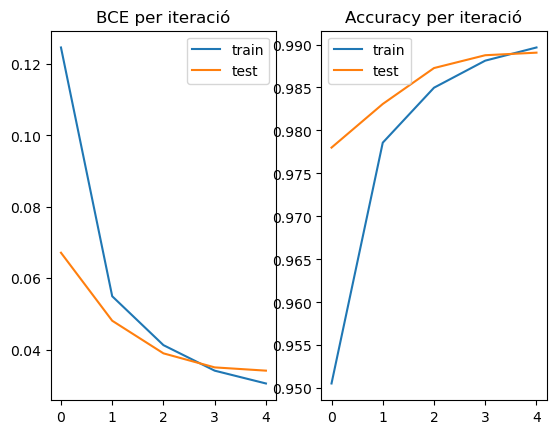

In [9]:
plt.subplot(1,2,1)
plt.title("BCE per iteració")
plt.plot(running_loss, label="train")
plt.plot(running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc, label="test")
plt.legend()
plt.show()

In [10]:
print(f"Accuracy de la darrera iteració {running_test_acc[-1]} amb test")

Accuracy de la darrera iteració 0.9890525477707006 amb test





### Nombre de paràmetres entrenables d'una xarxa

**Feina a fer:**
1. Mostrar el nombre de paràmetres de la xarxa: 
```
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
```

In [11]:
#TODO
pytorch_total_params = sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)
pytorch_total_params

7971

## Entrenament CNN

Ara repetirem el mateix que abans, adaptant el codi a la nova arquitectura:

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3 
optimizer = optim.Adam(model_cnn.parameters(), lr=learning_rate)

running_loss = []
running_acc = []
running_test_loss = []
running_test_acc_cnn = []

for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0

    model_cnn.train()

    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"):
        optimizer.zero_grad()

        
        y_pred = model_cnn(x)  # shape: [batch_size, 10]
        loss = loss_fn(y_pred, y)

        
        loss.backward()
        optimizer.step()

        
        preds = y_pred.argmax(dim=1)
        acc = (preds == y).float().mean().item()

        batch_loss += loss.item()
        batch_acc += acc

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    
    model_cnn.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for i_batch, (x, y) in enumerate(test_loader):
            y_pred = model_cnn(x)
            loss = loss_fn(y_pred, y)
            preds = y_pred.argmax(dim=1)
            acc = (preds == y).float().mean().item()

            test_loss += loss.item()
            test_acc += acc

    running_test_loss.append(test_loss / (i_batch + 1))
    running_test_acc_cnn.append(test_acc / (i_batch + 1))

    print(f"Època {t+1}: Train acc = {running_acc[-1]:.4f}, Test acc = {running_test_acc_cnn[-1]:.4f}")


Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Època 1: Train acc = 0.9162, Test acc = 0.9765


Batches (Època 2): 0it [00:00, ?it/s]

Època 2: Train acc = 0.9712, Test acc = 0.9829


Batches (Època 3): 0it [00:00, ?it/s]

Època 3: Train acc = 0.9789, Test acc = 0.9862


Batches (Època 4): 0it [00:00, ?it/s]

Època 4: Train acc = 0.9819, Test acc = 0.9875


Batches (Època 5): 0it [00:00, ?it/s]

Època 5: Train acc = 0.9846, Test acc = 0.9901


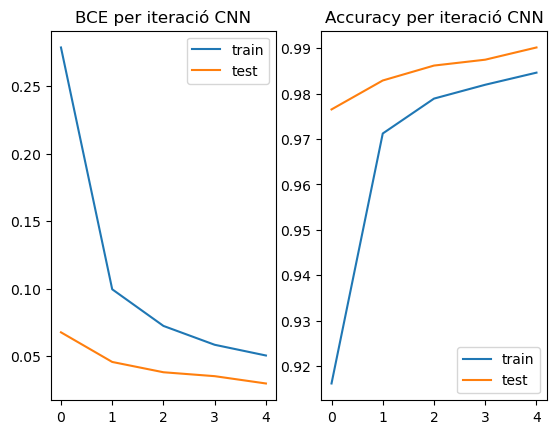

In [13]:
plt.subplot(1,2,1)
plt.title("BCE per iteració CNN")
plt.plot(running_loss, label="train")
plt.plot(running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració CNN")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc_cnn, label="test")
plt.legend()
plt.show()

In [14]:
running_test_acc_cnn[-1]

0.9901472929936306

Ara mirarem el nombre de paràmetres que té aquesta xarxa:

In [15]:

pytorch_total_params = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
pytorch_total_params

38922

## Resultats

Aquí visualitzarem els resultats d'aprenentatge de la xarxa. 

### Feina a fer:

1. Fer una predicció del primer _batch_ del conjunt de _test_.
2. Visualitzar una imatge del _batch_ i posar la predicció i el ground truth com a títol.
3. Empra una _CNN_ per resoldre el problema dels ocells que vàrem veure la setmana passada.



In [16]:
# Make predictions with CNN on the first batch of test images
x_img, y_true = next(iter(test_loader))
model_cnn.eval()
y_pred = model_cnn(x_img)

print("Predictions (logits):", y_pred.squeeze().detach().numpy())
print("Predictions (binary):", y_pred.squeeze().detach().numpy())
print("Ground truth:", y_true.numpy())

Predictions (logits): [[-1.02000551e+01 -3.41470337e+00 -7.46095061e-01 -1.76865435e+00
  -6.51038027e+00 -6.13815212e+00 -1.97601376e+01  1.40415096e+01
  -2.77506423e+00 -1.22896516e+00]
 [-9.55170929e-01  2.00248912e-01  1.57489500e+01 -9.62098885e+00
  -1.41476088e+01 -1.45666933e+01 -1.13850098e+01 -9.61765766e+00
  -7.49412107e+00 -1.15310755e+01]
 [-1.02638216e+01  1.16441212e+01 -4.94947624e+00 -1.03441315e+01
  -3.67661953e+00 -9.09094048e+00 -7.81691408e+00 -1.60034859e+00
  -5.21087551e+00 -5.75523281e+00]
 [ 1.66571026e+01 -1.03270664e+01 -5.05879545e+00 -1.22374792e+01
  -7.95149612e+00 -5.76651096e+00 -2.60413140e-01 -7.10196352e+00
  -4.77828074e+00 -2.62318635e+00]
 [-8.29376984e+00 -3.53612256e+00 -4.93441105e+00 -1.10601864e+01
   1.70136795e+01 -1.08842211e+01 -1.60379715e+01 -4.48137951e+00
  -7.49633837e+00  5.54637575e+00]
 [-1.14644117e+01  1.35676174e+01 -5.75943327e+00 -1.27390413e+01
  -3.91311932e+00 -1.19604540e+01 -1.00698776e+01 -1.42589617e+00
  -5.607607

In [17]:
x_img, y_true = next(iter(test_loader))
model_cnn.eval()
y_pred = model_cnn(x_img)
print(f"Predicted values: {y_pred}, Real values: {y_true}")

Predicted values: tensor([[-1.0200e+01, -3.4147e+00, -7.4610e-01, -1.7687e+00, -6.5104e+00,
         -6.1382e+00, -1.9760e+01,  1.4042e+01, -2.7751e+00, -1.2290e+00],
        [-9.5517e-01,  2.0025e-01,  1.5749e+01, -9.6210e+00, -1.4148e+01,
         -1.4567e+01, -1.1385e+01, -9.6177e+00, -7.4941e+00, -1.1531e+01],
        [-1.0264e+01,  1.1644e+01, -4.9495e+00, -1.0344e+01, -3.6766e+00,
         -9.0909e+00, -7.8169e+00, -1.6003e+00, -5.2109e+00, -5.7552e+00],
        [ 1.6657e+01, -1.0327e+01, -5.0588e+00, -1.2237e+01, -7.9515e+00,
         -5.7665e+00, -2.6041e-01, -7.1020e+00, -4.7783e+00, -2.6232e+00],
        [-8.2938e+00, -3.5361e+00, -4.9344e+00, -1.1060e+01,  1.7014e+01,
         -1.0884e+01, -1.6038e+01, -4.4814e+00, -7.4963e+00,  5.5464e+00],
        [-1.1464e+01,  1.3568e+01, -5.7594e+00, -1.2739e+01, -3.9131e+00,
         -1.1960e+01, -1.0070e+01, -1.4259e+00, -5.6076e+00, -6.0657e+00],
        [-1.3689e+01, -2.8511e+00, -8.9429e+00, -1.0257e+01,  1.1374e+01,
         -5.50